### Create CSV
This notebook will randomly select a subset of the full training set to use as labeled training data, and will save a CSV with (key, index) pairs to pass into the training script. The output will be stored in ../scripts/csv_samplers.


In [3]:
import csv
import numpy as np
import os
import random
from matplotlib import pyplot as plt
import glob, os
from shared_utils import *


In [4]:
# Set variables --- should only need to modify this cell for custom datasets

task = 'acdc' # Task name, should match the task name where data is stored
dataset_path = f'../data/{task}/train' # Path to directory where all training images are located
seg_path = f'../data/{task}/train' # Path to directory where all training seg masks are located, typically the same as dataset_path
save_path = '../scripts/csv_samplers' # Path to directory where CSV will be saved
n_keys = 5 # Number of patients to select, either set to an int or "all" to use all patients
n_slice_per_key = 'all' # Number of slices to select from each patient, if the patient's img is a volume; either int or "all" to use all slices in the volume
seed = 1 # Random seed


In [5]:
# Setup
all_keys = []
all_idx = []

np.random.seed(seed)
random.seed(seed)

if not os.path.exists(save_path): os.makedirs(save_path)
csv_fn = os.path.join(save_path, ('_').join([task,str(n_keys)+'-'+'keys',str(n_slice_per_key)+'-'+'slice-per-key','seed'+'-'+str(seed)])+'.csv')
print('Saving to',csv_fn)

# Select keys and image slice indices
with open(csv_fn, "a") as csv_file:
    writer = csv.writer(csv_file, delimiter=',')

    # Select which patients will be used as labeled data
    full_key_list = glob.glob(os.path.join(dataset_path,'*_image.npy'))
    full_key_list = [k for k in full_key_list if os.path.exists(os.path.join(seg_path,k.split('/')[-1].split('_image')[0]+'_seg.npy'))]
    key_list = [('_').join(k.split('/')[-1].split('_')[:-1]) for k in full_key_list]

    if n_keys=='all': 
        selected_key_list = key_list

    else:
        if len(key_list)>n_keys:
            selected_key_list = random.sample(key_list, n_keys)
        elif len(key_list)==n_keys:
            selected_key_list = key_list
        else:
            print('Warning, you have specified more training patients than are available in the data path; sampling with replacement.')
            selected_key_list = random.choices(key_list, k=n_keys)
    
    # Select which slices will be used as labeled data
    pairs_added = []
    for kind, key in enumerate(selected_key_list):

        # Managing image slices
        img = np.load(os.path.join(dataset_path,key+"_image.npy"))
        
        if n_slice_per_key == 'all':
            selected_slice_list = range(img.shape[-1])
        else: 
            # Select random slices
            if img.shape[-1]>n_slice_per_key:
                selected_slice_list = random.sample(range(img.shape[-1]), n_slice_per_key)
            elif img.shape[-1]==n_slice_per_key:
                selected_slice_list = range(img.shape[-1])
            else:
                print('Warning, you have specified more slices per image than are available in the data path; sampling with replacement.')
                selected_slice_list = random.choices(range(img.shape[-1]), k=n_slice_per_key)           

        # Save patient/slice into csv
        for sl in selected_slice_list:
            writer.writerow([key,sl])
            pairs_added += [(key,sl)]

print('Total number of patients available:', len(key_list))
print('Total number of patients added to the CSV:', len(selected_key_list))
print('Total number of unique patients added to the CSV:', len(set(selected_key_list)))
print('Total number of (patient, slice index) pairs added to the CSV:',len(pairs_added))
print('Total number of unique (patient, slice index) pairs added to the CSV:',len(set(pairs_added)))


Saving to ../scripts/csv_samplers/acdc_3-keys_1-slice-per-key_seed-1.csv
Total number of patients available: 5
Total number of patients added: 3
Total number of unique patients added: 3
Total number of (patient, slice index) pairs added: 3
Total number of unique (patient, slice index) pairs added: 3


Checking saved csv
Number of unique patients in csv: 5
Number of (patient, slice index) entries in csv: 53


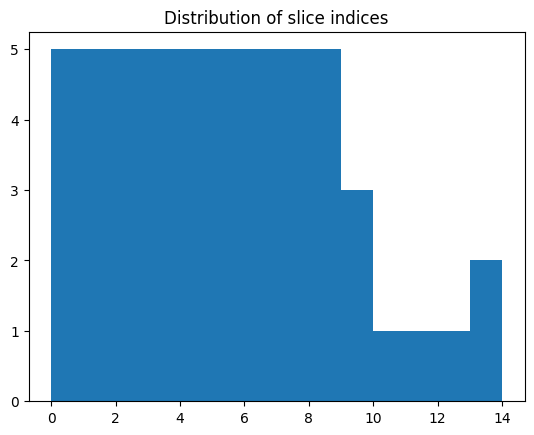

In [4]:
# Check CSV
all_keys = []
all_idxs = []
with open(csv_fn, newline='') as f:
    data = list(csv.reader(f))
    for key, idx in data:
        all_keys += [key]
        all_idxs += [idx]
print('Checking saved csv')
print('Number of unique patients in csv:',len(set(all_keys)))
print('Number of (patient, slice index) entries in csv:',len(all_idxs))

# Plot dist of slices
if len(np.unique(all_idxs))>1:
    plt.figure()
    plt.hist(np.asarray([int(i) for i in all_idxs]),bins=range(max([int(i) for i in all_idxs])+1))
    plt.title('Distribution of slice indices')
    plt.show()
    plt.close()